In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from scipy import stats

In [2]:
font = {'size': 16}
plt.rc('font', **font)

In [3]:
# ฟังก์ชันตรวจจับ Drip
def detect_drip(data, window=12, threshold=-0.05):
  drips = []
  for i in range(len(data) - window):
    # เพิ่มในฟังก์ชัน detect_drip
    if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
      continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
    
    close_price = data['close'].iloc[i]
    low_price = data['low'].iloc[i:i+window].min()
    drip_pct = (low_price - close_price) / close_price
    if drip_pct <= threshold:
      drips.append({
        'start_time': data.index[i],
        'close_price': close_price,
        'low_price': low_price,
        'drip_pct': drip_pct * 100,  # แปลงเป็น %
        'window_end_time': data.index[i+window-1]
      })
  
  return pd.DataFrame(drips)

In [4]:
data = pd.read_pickle(os.path.abspath("../../crypto/datasets/preprocessed/BTCUSDT/1h/features.pkl"))
#data = data["2024-01-01":"2024-12-31"]

Summary of Drip Sizes:
Number of Drips: 710.00
Mean Drip Size (%): -6.74
Std Drip Size (%): 2.73
Min Drip Size (%): -34.15
Max Drip Size (%): -5.00
Median Drip Size (%): -5.86


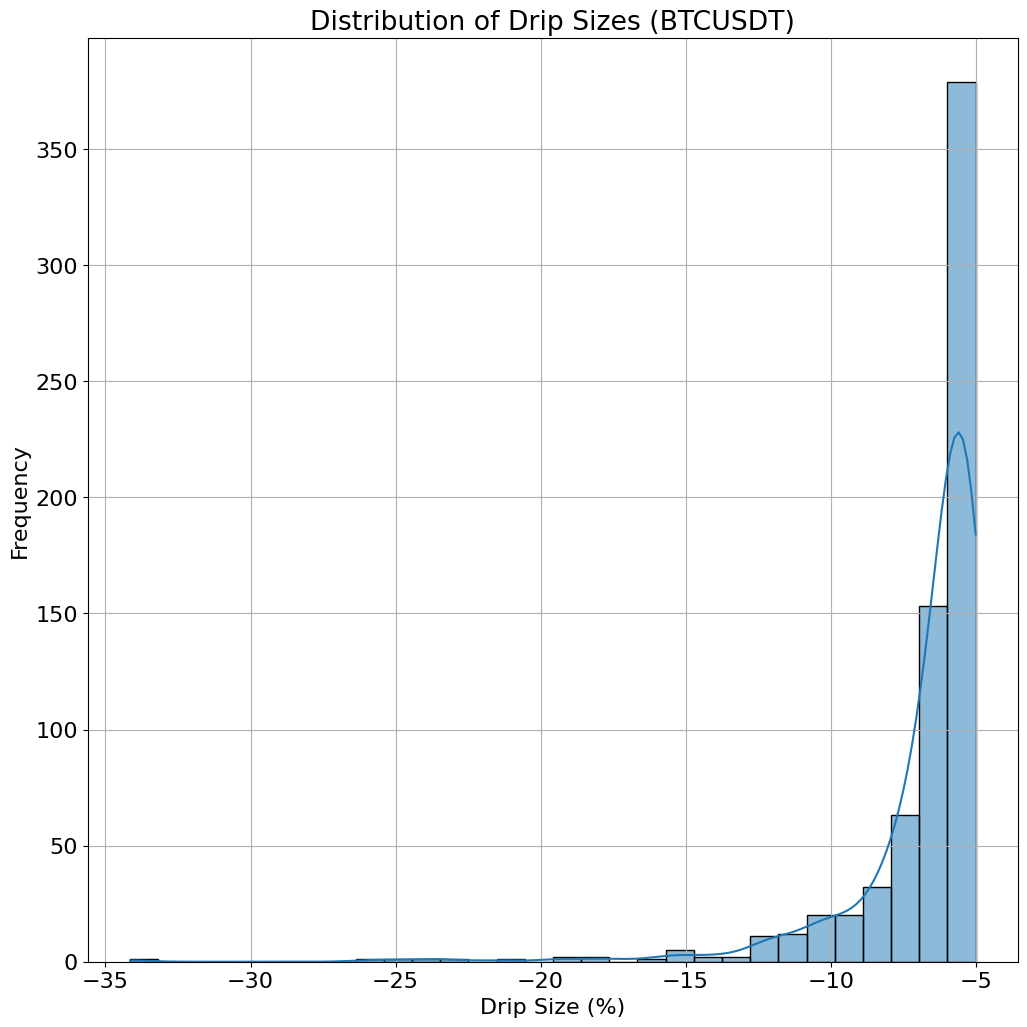

Shapiro-Wilk Test for Normality: stat=0.5788, p-value=0.0000
The distribution is not normal (p < 0.05)


In [5]:
drips = detect_drip(data, window=12, threshold=-0.05)

# สรุปสถิติของขนาด Drip
drip_summary = {
    'Number of Drips': len(drips),
    'Mean Drip Size (%)': drips['drip_pct'].mean(),
    'Std Drip Size (%)': drips['drip_pct'].std(),
    'Min Drip Size (%)': drips['drip_pct'].min(),
    'Max Drip Size (%)': drips['drip_pct'].max(),
    'Median Drip Size (%)': drips['drip_pct'].median()
}

print("Summary of Drip Sizes:")
for key, value in drip_summary.items():
    print(f"{key}: {value:.2f}")

# สร้างฮิสโตแกรมของขนาด Drip
plt.figure(figsize=(12, 12))
sns.histplot(drips['drip_pct'], bins=30, kde=True)
plt.title('Distribution of Drip Sizes (BTCUSDT)')
plt.xlabel('Drip Size (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# ทดสอบความปกติของการแจกแจง (Shapiro-Wilk Test)
stat, p_value = stats.shapiro(drips['drip_pct'])
print(f"Shapiro-Wilk Test for Normality: stat={stat:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("The distribution is not normal (p < 0.05)")
else:
    print("The distribution is normal (p >= 0.05)")

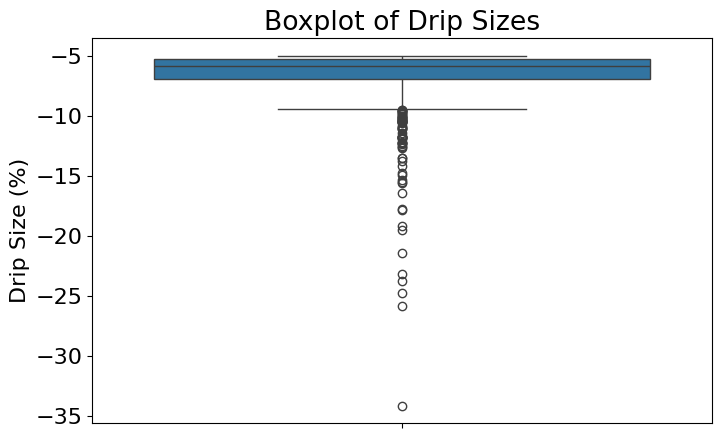

In [6]:
plt.figure(figsize=(8, 5))
sns.boxplot(y=drips['drip_pct'])
plt.title('Boxplot of Drip Sizes')
plt.ylabel('Drip Size (%)')
plt.show()